<a href="https://colab.research.google.com/github/matsunagalab/ColabBTR/blob/main/dilation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Example of dilation

This notebook consists of the following steps:
1. Retrieves the XYZ coordinates of a biomolecule from the Protein Data Bank (PDB)
2. Calculates the height of the molecular surface on a grid from the XYZ coordinates
3. Obtains a dilated image by dilating the molecular surface with a certain tip shape

In [ ]:
#@title Install dependencies
%%time
import os

print("installing colabbtr...")
os.system("pip install -q --no-warn-conflicts git+https://github.com/matsunagalab/ColabBTR")

print("installing libasd...")
os.system("pip install -q --no-warn-conflicts libasd")

print("installing mdtraj...")
os.system("pip install -q --no-warn-conflicts mdtraj")

installing colabbtr...
installing libasd...
installing mdtraj...
CPU times: user 677 ms, sys: 77.6 ms, total: 755 ms
Wall time: 2min 46s


0

In [57]:
# load the atom coordinates from PDB and store as a tensor (Natom x 3)

import torch
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt

from colabbtr.morphology import Atom2Radius
from colabbtr.morphology import surfing
from colabbtr.morphology import idilation

pdb_id = "1OE9"
traj = md.load_pdb(f"http://www.rcsb.org/pdb/files/{pdb_id}.pdb")
ca_atoms = traj.topology.select('name CA and chainid 0')
traj = traj.atom_slice(ca_atoms)
xyz = traj.xyz[0, :, :]
xyz = torch.tensor(xyz, dtype=torch.float32)

In [58]:
# remove the center of mass and then z_min to z=0

xyz -= xyz.mean(dim=0)
xyz[:, 2] -= xyz[:, 2].min()

In [60]:
# get radii of residues and store as a tensor (Natom x 1)

radii = []
for residue in traj.topology.residues:
    residue_name = residue.name
    if residue_name in Atom2Radius:
        radii.append(Atom2Radius[residue_name])
    else:
        print(f"Warning: Radius not found for residue {residue_name}")
        radii.append(None)

radii = torch.tensor(radii, dtype=torch.float32)

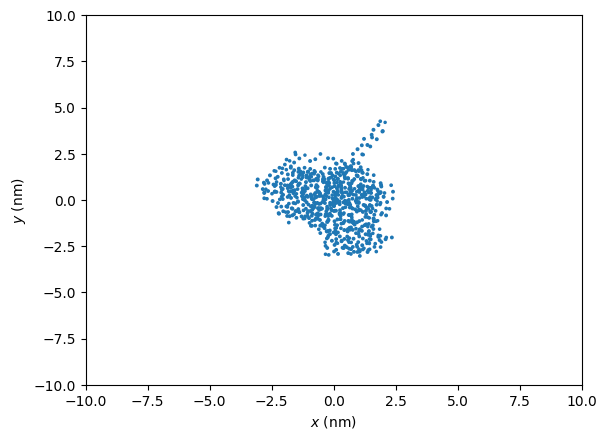

In [59]:
# scatter of atom coordinates in xy plane

plt.scatter(xyz[:, 0], xyz[:, 1], s=radii*10)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel(r"$x$ (nm)")
plt.ylabel(r"$y$ (nm)" )
plt.show()

In [61]:
# creat molecular surface 2D tensor with a specified resolution

# specify range and resolution in nm
config = {"min_x":-10.0, "max_x":10.0,
          "min_y":-10.0, "max_y":10.0,
          "resolution_x":1.0,
          "resolution_y":1.0}

surface = surfing(xyz, radii, config)

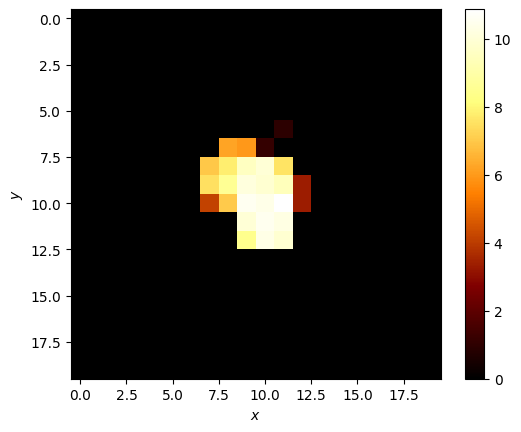

In [62]:
# visualize molecular suface 2D tensor

plt.imshow(surface, interpolation='none', origin='upper',
           cmap="afmhot", aspect="equal")
           #vmin=0.0, vmax=5.0)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$" )
plt.colorbar()

In [63]:
# load tip shape as 2D tensor

!pip install --upgrade gdown

!gdown 1hdAVE5ZljRsLgX2QGt6hytLemChDMxg9

tip = np.load("tip.npy")
tip = torch.tensor(tip, dtype=torch.float32).contiguous()

Downloading...
From: https://drive.google.com/uc?id=1hdAVE5ZljRsLgX2QGt6hytLemChDMxg9
To: /content/tip.npy
100% 880/880 [00:00<00:00, 4.36MB/s]


In [64]:
# dilate the molecular surface and obtain a dilate image 2D tensor

image = idilation(surface, tip)

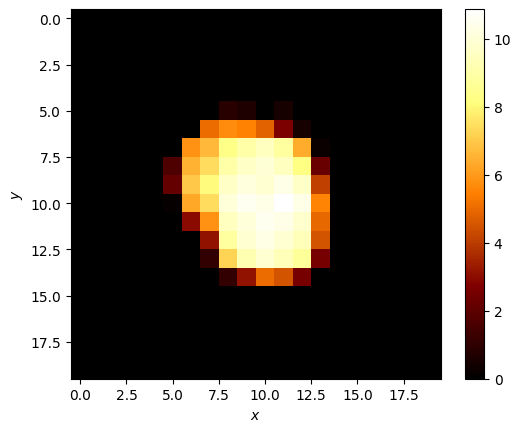

In [65]:
# visualize the dilated image

plt.imshow(image, interpolation='none', origin='upper',
           cmap="afmhot", aspect="equal")
           #vmin=0.0, vmax=1.0)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$" )
plt.colorbar()